In [1]:
# drive access

from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [2]:
drive_path = "/content/drive/MyDrive/Colab_Notebooks/unet_neuoral_membranse/" 

In [3]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

import numpy as np 
import cv2 as cv

import re
import glob

NET_INPUT_SIZE = (572, 572)
NET_OUTPUT_SIZE = (388, 388)

In [4]:
import sys
import os

py_file_location = drive_path
sys.path.append(os.path.abspath(py_file_location))
from unet import UNet     # unet.py must be in drive_path

In [5]:
def Normalize(img):
    return np.array(img/255.0, dtype=np.float32)

def Shape_Process(img):
    if img.shape > NET_INPUT_SIZE:
        img = cv.resize(img, NET_INPUT_SIZE, interpolation = cv.INTER_CUBIC)   # image reduction
        
    elif img.shape < NET_INPUT_SIZE:
        if img.shape[0] % 2:
            img = cv.resize(img, img.shape[0] // 2, interpolation = cv.INTER_CUBIC)
        padd = int((NET_INPUT_SIZE[0] - img.shape[0]) / 2)
        img = cv.copyMakeBorder(img, padd, padd, padd, padd, cv.BORDER_REFLECT_101)
        
    return img

def Center_Crop(img):
    img = Shape_Process(img)
    crop_yx = (int((img.shape[0] - NET_OUTPUT_SIZE[0]) / 2), int((img.shape[1] - NET_OUTPUT_SIZE[1]) / 2))
    img = img[crop_yx[0]: crop_yx[0] + NET_OUTPUT_SIZE[0], crop_yx[1]: crop_yx[1] + NET_OUTPUT_SIZE[1]]
    
    return img

def Numerical_Sort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def Read_Images_Test(folder_path, image_names):
    images = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        img = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        img = Shape_Process(img)
        images.append(Normalize(img))
    
    images = np.asarray(images, dtype=np.float32)
    images = images[:, :, :, np.newaxis, np.newaxis]    # format => [N, H, W, C1, C2]
    return images

def Read_Images_Train(folder_path, image_names):
    images = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        img = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        img = Shape_Process(img)
        images.append(Normalize(img))
    
    images = np.asarray(images, dtype=np.float32)
    images = images[:, :, :, np.newaxis]    # format => [N, H, W, C]
    return images

def Read_Images_GTruth(folder_path, image_names):
    labels = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        mask = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        mask = Center_Crop(mask)
        mask = Normalize(mask)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        labels.append(mask)
    
    labels = np.asarray(labels, dtype=np.float32)
    labels = labels[:, :, :, np.newaxis]    # format => [N, H, W, C]
    return labels

def Matplotlib_Imshow(img):
    npimg = img.cpu().detach().numpy()
    npimg = (npimg * 255.0).astype("int")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


In [6]:
#%% dataset load and preprocessing

test_images_path = drive_path + "data/test/*.tif"
train_gtruth_path = drive_path + "data/train/labels/*.tif"
train_images_path = drive_path + "data/train/images/*.tif"


test_images = []
image_names = []
train_gtruth = []
train_images = []
test_images = Read_Images_Test(test_images_path, image_names)
train_images = Read_Images_Train(train_images_path, image_names)    
train_gtruth = Read_Images_GTruth(train_gtruth_path, image_names)

In [7]:
#%%
# Create data loaders.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# pytorch input format => [N, H, W, C1] -> [N, C1, H, W]
train_tensor = torch.from_numpy(train_images).transpose_(2 , 3).transpose_(1 , 2).float().to(device)
train_gtruth_tensor = torch.from_numpy(train_gtruth).transpose_(2 , 3).transpose_(1 , 2).float().to(device)
# pytorch input format => [N, H, W, C1, C2] -> [N, C1, C2, H, W]
test_tensor = torch.from_numpy(test_images).transpose_(1 , 3).transpose_(2 , 4).float().to(device)

batch_size = 10
train_dl = DataLoader(train_tensor, batch_size=batch_size, shuffle=False)
train_gtruth_dl = DataLoader(train_gtruth_tensor, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_tensor, batch_size = len(test_images), shuffle=False)
test_iter = next(iter(test_dl))


Using cuda device


In [8]:
#%% create model
model = UNet().to(device)
print(model)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
epoch = 300

#%% train
for e in range(epoch):
    for i in range(len(train_dl)):
        train_iter = next(iter(train_dl))
        train_gtruth_iter = next(iter(train_gtruth_dl))
        optim.zero_grad()
        prediction = model(train_iter)
        loss = F.mse_loss(prediction, train_gtruth_iter)
        loss.backward()
        optim.step()
    print("Epoch :" + str(e) + "\t", end="\n")
    print(loss)

print('Finished Training')

UNet(
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.5, inplace=False)
  (conv1): Double_Conv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv2): Double_Conv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv3): Double_Conv(
    (double_conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv4): Double_Conv(
    (double_conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stri

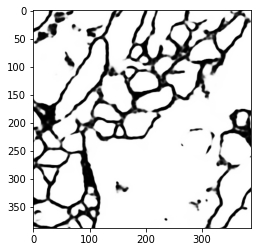

In [9]:
test_img_index = 0
test_prediction = model(test_iter[test_img_index])   
img_grid = make_grid(test_prediction)

# show images
Matplotlib_Imshow(img_grid)

In [10]:
# model save
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


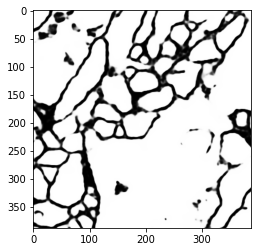

In [11]:
# model load
model_test = UNet().to(device)
model_test.load_state_dict(torch.load("model.pth"))

test_prediction = model_test(test_iter[0])
img_grid = make_grid(test_prediction)

# show images
Matplotlib_Imshow(img_grid)